https://github.com/utkuozbulak/pytorch-custom-dataset-examples/tree/master/src

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

import numpy as np
import cv2
# from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import glob
import torch
import torchvision
from torch.utils.data.dataset import Dataset

# Create Dataset

In [2]:
class saveatacatdog(Dataset):
    def __init__(self, folder_path):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms
        Args:
            folder_path (string): path to image folder
        """
        # Get image list
        self.image_list = glob.glob(folder_path+'*')
        # Calculate len
        self.data_len = len(self.image_list)

    def __getitem__(self, index):
        # Get image name from the path
        single_image_path = self.image_list[index]
        # Open image
        # im_as_im = Image.open(single_image_path) #original
        im_gray = cv2.imread(single_image_path, cv2.IMREAD_GRAYSCALE)
        im_gray = cv2.resize(im_gray, (100,100))
        # Do some operations on image
        # Convert to numpy, dim = 28x28
        
        
        # im_as_np = np.asarray(im_as_im)/255 #original
        # sudo apt-get install fdupes
        
        # Add channel dimension, dim = 1x28x28
        # Note: You do not need to do this if you are reading RGB images
        # or i there is already channel dimension
        # im_as_np = np.expand_dims(im_as_np, 0)

        # Transform image to tensor, change data type
        # im_as_ten = torch.from_numpy(im_as_np).float() #original
        im_as_ten = torch.from_numpy(im_gray/255).float()
        # Get label(class) of the image based on the file name
        # Let cat = 0, dog = 1
        
        # class_indicator_location = single_image_path.rfind('dog')
        # label = int(single_image_path[class_indicator_location+2:class_indicator_location+3])
        if "cat" in single_image_path:
            label = 0
        else:
            label = 1
        return (im_as_ten, label)

    def __len__(self):
        return self.data_len

# View and Verify Created Dataset

In [3]:
dataset_train = mondatacatdog('/home/airlab/YUTH/DL/dataset_mix/train/')
dataset_test  = mondatacatdog('/home/airlab/YUTH/DL/dataset_mix/test/')
print(dataset_train.data_len)
print(dataset_train.image_list[0])
print(dataset_test.data_len)
print(dataset_test.image_list[0])

8000
/home/airlab/YUTH/DL/dataset_mix/train/cat.701.jpg
2000
/home/airlab/YUTH/DL/dataset_mix/test/cat.4465.jpg


torch.Size([100, 100])
1


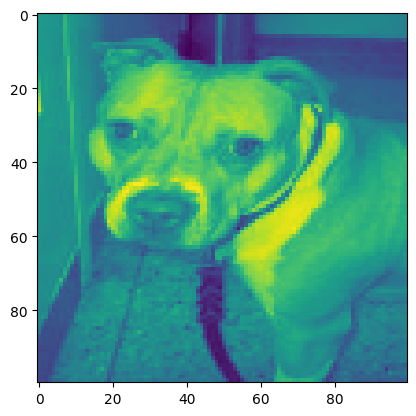

In [4]:
imt, label = dataset_train.__getitem__(7520)
print(imt.size())
print(label)
plt.imshow(imt)

# Load Data Set

In [40]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset = dataset_train , batch_size = 8, shuffle = True)
dataloader_test  = DataLoader(dataset = dataset_test  , batch_size = 2000)#, shuffle = True)
print(len(dataloader_train))
print(len(dataloader_test))

1000
1


In [6]:
for img, targ in dataloader_train:
    print(img.shape)
    print(targ.shape)
    break

torch.Size([8, 100, 100])
torch.Size([8])


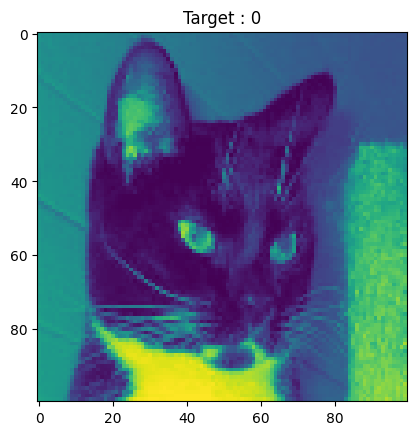

In [7]:
from IPython.display import clear_output
import time
for i in range(7):
    plt.imshow(img[i])
    plt.title("Target : " + str(targ[i].item()))
    plt.show()
    time.sleep(1)
    clear_output(wait=True)

# Create Model

In [10]:
class Model(nn.Module):
    def __init__(self,nm_class = 2):
        super(Model,self).__init__()
        self.nm_class = nm_class
        self.linear1 = nn.Linear(100*100,100*100*2)
        self.linear2 = nn.Linear(100*100*2,nm_class)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(100*100*2)

    def forward(self, x):
        # we have image (8,1,28,28), we want to (8,28*28)
        x = x.reshape(x.shape[0],-1)
        x = self.linear1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [11]:
model = Model(nm_class = 2).to("cuda")
print(model)

Model(
  (linear1): Linear(in_features=10000, out_features=20000, bias=True)
  (linear2): Linear(in_features=20000, out_features=2, bias=True)
  (relu): ReLU()
  (bn): BatchNorm1d(20000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
# fake data
f_data = torch.rand((8,100,100)).to("cuda")
outp = model(f_data)
print(f_data.shape)
print(outp.shape)

torch.Size([8, 100, 100])
torch.Size([8, 2])


# Create Loss and Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.0003)

# Trainning

In [15]:
#train
for epc in range(50):
    model.train()
    num_cor = 0
    num_samp = 0
    loss_list = []
    for data,target in dataloader_train:
        data = data.to("cuda")
        target = target.to("cuda")

        #forward
        output = model(data)
        loss = criterion(output,target)
        loss_list.append(loss)
        
        _,pred = output.max(1)

        num_cor += (pred == target).sum()
        num_samp += pred.size(0)
        

        #backward
        optimizer.zero_grad()
        loss.backward()

        #grad decent or adam
        optimizer.step()
    acc = num_cor/num_samp
    print("EPC : "+str(epc)+"   Acc:  "+str(acc))

EPC : 0   Acc:  tensor(0.5165, device='cuda:0')
EPC : 1   Acc:  tensor(0.5458, device='cuda:0')
EPC : 2   Acc:  tensor(0.5464, device='cuda:0')
EPC : 3   Acc:  tensor(0.5711, device='cuda:0')
EPC : 4   Acc:  tensor(0.5871, device='cuda:0')
EPC : 5   Acc:  tensor(0.5876, device='cuda:0')
EPC : 6   Acc:  tensor(0.6155, device='cuda:0')
EPC : 7   Acc:  tensor(0.6394, device='cuda:0')
EPC : 8   Acc:  tensor(0.6576, device='cuda:0')
EPC : 9   Acc:  tensor(0.6838, device='cuda:0')
EPC : 10   Acc:  tensor(0.6989, device='cuda:0')
EPC : 11   Acc:  tensor(0.7134, device='cuda:0')
EPC : 12   Acc:  tensor(0.7490, device='cuda:0')
EPC : 13   Acc:  tensor(0.7656, device='cuda:0')
EPC : 14   Acc:  tensor(0.7828, device='cuda:0')
EPC : 15   Acc:  tensor(0.7826, device='cuda:0')
EPC : 16   Acc:  tensor(0.8108, device='cuda:0')
EPC : 17   Acc:  tensor(0.8224, device='cuda:0')
EPC : 18   Acc:  tensor(0.8310, device='cuda:0')
EPC : 19   Acc:  tensor(0.8396, device='cuda:0')
EPC : 20   Acc:  tensor(0.8466

# Testing Set

In [39]:
fff_data = torch.rand((2,100,100)).to("cuda")
outppp = model(fff_data)
print(fff_data.shape)
print(outppp.shape)

torch.Size([2, 100, 100])
torch.Size([2, 2])


----------------------STARTING TO PREDICT----------------------
The ground trust is : 1
The prediction is if 0 is cat and 1 is dog. and the model say that : 1


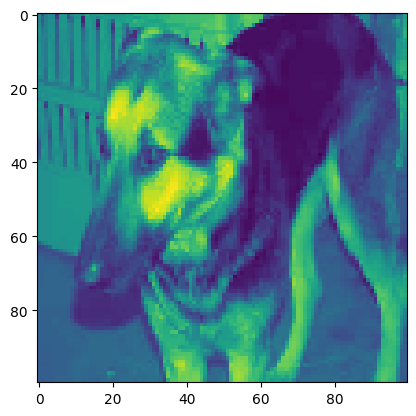

In [43]:
index = 555
for imgt, targt in dataloader_test:
    # print(imgt.size())
    # print(imgt[1].size())
    print("----------------------STARTING TO PREDICT----------------------")
    pred = model(imgt.to("cuda"))
    print("The ground trust is : %d"%targt[index].item())
    print("The prediction is if 0 is cat and 1 is dog. and the model say that : %d"%pred[index].argmax().item())
    plt.imshow(imgt[index])
    break

# Save and Load Model

In [16]:
torch.save(model, "modelsave.pt")

In [ ]:
model = torch.load("./modelsave.pt")
model.eval()